# Pretrained birds species models for Mt Kenya Species

In this notebook we demonstrate the performance of an open pretrained model on Mt Kenya species. We use [Perch](https://www.kaggle.com/models/google/bird-vocalization-classifier) as the pretrained model.

## Local Data
We have data obtained from the Dedan Kimathi University Wildlife Conservancy and Mt Kenya National Park that has been annotated by experts. We will focus on recordings with a single species.

In [1]:
import os
import json
import random
import librosa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import bvc_helper_funcs as bhf

import IPython.display as ipd
import ipywidgets as widgets

2025-02-16 19:21:06.369937: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-16 19:21:06.394176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 19:21:06.394198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 19:21:06.394802: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 19:21:06.398567: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-16 19:21:06.399166: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
with open('../annotations/single_species_filenames.json', 'r') as fp:
    single_species_filenames = json.load(fp)

## Select a species to listen to and plot spectrogram.


In [3]:
audio_dir = '../audio'

In [4]:
sp_select = widgets.Dropdown(
    options=['Tropical Boubou', "Hartlaub's Turaco", 'Yellow-whiskered Greenbul'],
    value='Yellow-whiskered Greenbul',
    description='Species:',
    disabled=False,
)

In [5]:
display(sp_select)

Dropdown(description='Species:', index=2, options=('Tropical Boubou', "Hartlaub's Turaco", 'Yellow-whiskered G…

In [6]:
# Select species files 
# starts with 'D' selects DeKUWC
# starts with 'M' selects MKNP
sp_files = [k for k,v in single_species_filenames.items() if v == sp_select.value and k.startswith('D')]

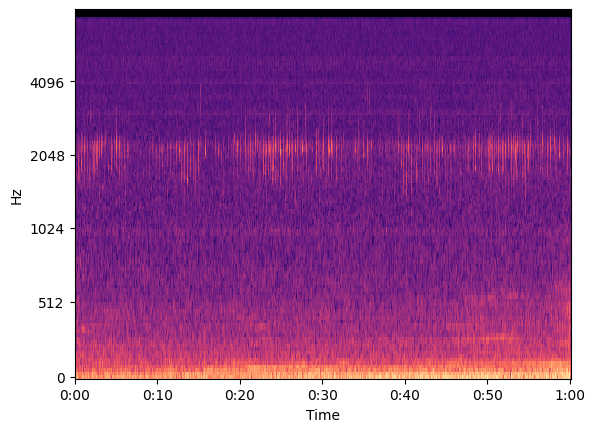

In [7]:
sp_file = random.choice(sp_files)


audio, sampling_rate = librosa.load(os.path.join(audio_dir, sp_file), sr=None)

window_ms = 40
window_samples = int((window_ms * sampling_rate) / 1000)

n_fft = int(2 ** np.ceil((np.log2(window_samples))))
hop_length = int(0.25 * window_samples)

S = librosa.feature.melspectrogram(y=audio,
                                   sr=sampling_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   n_mels=128,
                                   fmax=8000)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, 
                               x_axis='time',
                               y_axis='mel', 
                               sr=sampling_rate,
                               n_fft=n_fft,
                               hop_length=hop_length,
                               fmax=8000, 
                               ax=ax)

In [8]:
ipd.Audio(os.path.join('../audio/', sp_file))

# Perch Classification

Perch is trained to recognise a number of Kenyan species including the Tropical Boubou, Hartlaub's Turaco and Yellow-whiskered Greenbul. The over 10k species represented in Perch are represented using the eBird species code. 

In [9]:
# get perch model and labels

model, labels = bhf.load_model()
ebird_labels = pd.read_csv(labels)
ebird_labels = list(ebird_labels['ebird2021'])

2025-02-16 19:21:11.305754: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [10]:
# ebird
df_ebird = pd.read_csv('../annotations/ebird_taxonomy_v2023.csv')

In [11]:
df_ebird.head()

,TAXON_ORDER,CATEGORY,SPECIES_CODE,TAXON_CONCEPT_ID,PRIMARY_COM_NAME,SCI_NAME,ORDER,FAMILY,SPECIES_GROUP,REPORT_AS
0,2,species,ostric2,avibase-2247CB05,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,7,species,ostric3,avibase-40329BB6,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
2,8,slash,y00934,avibase-5D14080C,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
3,10,species,grerhe1,avibase-00986B24,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,16,species,lesrhe2,avibase-590ADF92,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),Rheas,NaN


In [12]:
# get the ebird code
sp_index = df_ebird[df_ebird['PRIMARY_COM_NAME']==sp_select.value]['SPECIES_CODE'].iloc[0]

In [13]:
ebird_labels.index(sp_index)

10886

# Perch Processing

Perch divides the audio into segments 5 seconds long and computes the embeddings. We can examine the logits (outputs of the softmax layer) and find the maximum logit. We see if any of the segment is correctly classified

In [14]:
audio, sampling_rate = librosa.load(os.path.join(audio_dir, sp_file), sr=32000)
_, wav_data = bhf.ensure_sample_rate(audio, sampling_rate)
test_frames = bhf.frame_audio(wav_data, hop_size_s=5)

all_logits, _ = model.infer_tf(test_frames[:1])
for window in test_frames[1:-1]:
    logits, _ = model.infer_tf(window[np.newaxis, :])
    all_logits = np.concatenate([all_logits, logits], axis=0)

2025-02-16 19:21:14.988552: I external/local_xla/xla/service/service.cc:168] XLA service 0x2414c900 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-02-16 19:21:14.988589: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-02-16 19:21:15.389691: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739722877.737292  156243 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-02-16 19:21:17.753526: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


In [15]:
for i in range(all_logits.shape[0]):
    print(sp_index, ebird_labels[np.argmax(all_logits[i,:])])
    

yewgre1 yewgre1
yewgre1 yewgre1
yewgre1 yewgre1
yewgre1 yewgre1
yewgre1 yewgre1
yewgre1 yewgre1
yewgre1 yewgre1
yewgre1 whfant1
yewgre1 yewgre1
yewgre1 yewgre1
yewgre1 yewgre1
yewgre1 yewgre1
